In [192]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import binom
from scipy.stats import norm,chi2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed

Volatility of returns assuming static volatility =  0.01212293047222375
VaR with 95% confidence assuming static volatility =  0.018708513014307086
Fraction of exceptions from simple VaR analysis =  0.05015923566878981
But this doesn't capture the time-dependence of volatility. So, we'll analyse the VaR and exceptions for time-dependent volatility.
EWMA model for time-dependence of volatility 
Actual fraction of exceptions from EWMA model =  0.06130573248407643
Expected fraction of exceptions =  0.05
P from EWMA model using Kupiec's test = 0.07534222352244169 >0.05, thus OK
P from EWMA model using Christoffersen's test = 0.7162194728927753 >0.05, thus OK



/var/folders/9b/dz57jffx5337gh49s3hql0z40000gn/T/ipykernel_44193/3186484742.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ewma_variance[i]=lam_*ewma_variance[i-1]+(1-lam_)*portfolio_returns[i-1]**2


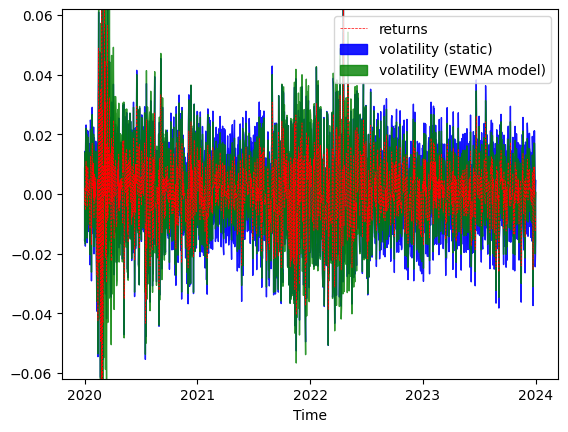

In [193]:
#Assign tickers, calculate returns
tickers=['AAPL', 'MSFT', 'SPY', 'TLT']
weights=[0.25, 0.25,0.25,0.25]
data=yf.download(tickers,start="2020-01-01",end="2024-12-31",group_by=tickers,auto_adjust=False)
adj_close=yf.download(tickers,start="2020-01-01",end="2024-12-31",auto_adjust=False)[["Adj Close"]]
returns=adj_close.pct_change().dropna()
portfolio_returns=returns.dot(weights)
# Calculate volatility of returns
portfolioreturnvalues=portfolio_returns.values
vol=portfolioreturnvalues.std()
print("Volatility of returns assuming static volatility = ",vol)
#Calculate VaR
var95=portfolio_returns.quantile(0.05)
print("VaR with 95% confidence assuming static volatility = ",-var95)
exceptions0=portfolioreturnvalues<var95
print("Fraction of exceptions from simple VaR analysis = ",exceptions0.sum()/len(portfolio_returns))
print("But this doesn't capture the time-dependence of volatility. So, we'll analyse the VaR and exceptions for time-dependent volatility.")
#Volatility analysis: 
#Calculate EWMA volatility
print("EWMA model for time-dependence of volatility ")
lam_=0.94
ewma_variance=np.zeros(len(portfolio_returns))
ewma_variance[0]=vol**2
for i in range(1,len(portfolio_returns)):
    ewma_variance[i]=lam_*ewma_variance[i-1]+(1-lam_)*portfolio_returns[i-1]**2
ewma_volatility=np.sqrt(ewma_variance)
z95=-1.645
VaR95ewma=z95*ewma_volatility
#Backtest (1) - Count exceptions from EWMA model
exceptions=portfolioreturnvalues<VaR95ewma
x=exceptions.sum()
p=0.05
N=len(portfolio_returns)
pactual=x/N
print("Actual fraction of exceptions from EWMA model = ",pactual)
print("Expected fraction of exceptions = ",p)

#Backtest (2) - Determine acceptibility by Calculating POF from Kupiec's test

logl0=np.log(p**x*(1-p)**(N-x))
logl1=np.log(pactual**x*(1-pactual)**(N-x))

teststatistickupiec=-2*(logl0-logl1)
print("P from EWMA model using Kupiec's test =", 1-chi2.cdf(teststatistickupiec,df=1), ">0.05, thus OK")

#Backtest (3) - Determine acceptibility by Calculating POF from Christoffersen's test
n00=n01=n10=n11=0
for i in range(1,len(portfolio_returns)):
    previous=exceptions[i-1]
    current=exceptions[i]
    if previous==0 and current==0:
        n00+=1
    if previous==1 and current==0:
        n10+=1
    if previous==0 and current==1:
        n01+=1
    if previous==1 and current==1:
        n11+=1
        
p01=n01/(n01+n00) if (n01+n00)>0 else 0
p11=n11/(n10+n11) if (n10+n11)>0 else 0
phat=(n01+n11)/(n00+n01+n10+n11)

logl0=np.log(phat**(n01+n11)*(1-phat)**(n10+n00))
logl1=np.log(p01**n01*(1-p01)**n00*p11**n11*(1-p11)**n10)

teststatisticchristoffersen=-2*(logl0-logl1)
print("P from EWMA model using Christoffersen's test =", 1-chi2.cdf(teststatisticchristoffersen,df=1), ">0.05, thus OK")

plt.xlabel("Time")
#plt.xticks(2020,2022)
plt.ylim(-0.062,0.062)
plt.xticks(ticks=[2020, 2021, 2022, 2023, 2024])
plt.plot(np.linspace(2020,2024,N),portfolioreturnvalues,linestyle='--',color="red",linewidth="0.5",label="returns")
plt.fill_between(np.linspace(2020,2024,N),portfolioreturnvalues-vol*np.ones(N),portfolioreturnvalues+vol*np.ones(N),alpha=0.9,color="blue",label="volatility (static)")
plt.fill_between(np.linspace(2020,2024,N),portfolioreturnvalues-ewma_volatility,portfolioreturnvalues+ewma_volatility,alpha=0.8,color="green",label="volatility (EWMA model)")
plt.legend()


In [191]:
pip install arch


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [194]:
from arch import arch_model
returnpct=100*portfolioreturnvalues
model=arch_model(returnpct,vol="GARCH",p=1,q=1)
fit=model.fit(disp="off")
garch_vol=fit.conditional_volatility/100
#calculate VaR with 95 % confidence
z95=1.645
var95garch=-z95*garch_vol
#Backtesting: calculate fraction of exceptions from garch
exceptions_garch=portfolioreturnvalues<var95garch
xgarch=exceptions_garch.sum()
pactual_garch=xgarch/N
#Backtesting: calculate POF from garch model using Kupiec's test
logl0=np.log(p**xgarch*(1-p)**(N-xgarch))
logl1=np.log(pactual_garch**xgarch*(1-pactual_garch)**(N-xgarch))
test_statistic_garch=-2*(logl0-logl1)
p_garch_kupiec=1-chi2.cdf(test_statistic_garch,df=1)
print("P from GARCH model using Kupiec's test =",pof_garch_kupiec,">0.05, thus OK.")
#Backtesting: calculate POF from garch model using Christoffersen's test
n00=n01=n10=n11=0
for i in range(1,len(portfolioreturnvalues)):
    previous=exceptions_garch[i-1]
    current=exceptions_garch[i]
    if previous==0 and current==0:
        n00+=1
    elif previous==0 and current==1:
        n01+=1
    elif previous==1 and current==0:
        n10+=1
    elif previous==1 and current==1:
        n11+=1
        
p01=n01/(n00+n01) if (n00+n01)>0 else 0
p11=n11/(n10+n11) if (n10+n11)>0 else 0
phat=(n01+n11)/(n00+n01+n10+n11) if (n00+n01+n10+n11)>0 else 0

logl0=np.log(phat**(n01+n11)*(1-phat)**(n10+n00))
logl1=np.log(p01**n01*(1-p01)**n00*p11**n11*(1-p11)**n10)
test_statistic_garch=-2*(logl0-logl1)
p_garch_christoffersen=1-chi2.cdf(test_statistic_garch,df=1)
print("P from GARCH model using pof_garch_christoffersen's test =",pof_garch_christoffersen,">0.05, thus OK.")


P from GARCH model using Kupiec's test = 0.9793527694377908 >0.05, thus OK.
P from GARCH model using pof_garch_christoffersen's test = 0.4631582838500904 >0.05, thus OK.
